# 04 Final Option Pricing: Neural Path Integral Integration

이 노트북은 앞서 구현한 Heston 시뮬레이터, Path Integral Solver, 그리고 AI Calibrator의 요소들을 통합하여 최종적으로 옵션 가격을 산출하는 과정을 보여줍니다.

### 주요 단계:
1. **데이터 생성**: Heston 모델을 이용한 주가 경로 시뮬레이션
2. **작용(Action) 계산**: 각 경로의 물리적 발생 확률(Action) 측정
3. **경로 가중치 적용**: Path Integral 이론에 따른 경로별 가중치 부여
4. **옵션 가격 결정**: 가중 평균 페이오프(Payoff)를 통한 가격 산출 및 시각화

In [1]:
import sys
import os
import torch
import matplotlib.pyplot as plt
import numpy as np

# 프로젝트 루트 경로 추가
sys.path.append(os.path.abspath('..'))

from src.physics_engine import HestonSimulator
from src.quantum_solver import PathIntegralSolver
from src.utils import set_seed, to_numpy, plot_weighted_paths

# 재현성을 위한 시드 고정
set_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


## 1. 하이퍼파라미터 설정 및 시뮬레이션
시장 환경(Risk-free rate, Strike Price 등)과 Heston 파라미터를 설정합니다.

In [2]:
# Heston 파라미터
params = {
    'mu': 0.03,      # 무위험 이자율 가정
    'kappa': 2.5,   # 평균 회귀 속도
    'theta': 0.04,  # 장기 평균 변동성
    'xi': 0.5,      # Vol of Vol
    'rho': -0.7     # 주가-변동성 상관관계
}

S0 = 100.0
v0 = 0.04
T = 0.5         # 6개월 만기
dt = 1/252      # 일일 단위
K = 105.0       # 행사가 (OTM Call)
num_paths = 5000

# 1. 시뮬레이션 수행
sim = HestonSimulator(**params, device=device)
S_paths, v_paths = sim.simulate(S0=S0, v0=v0, T=T, dt=dt, num_paths=num_paths)

print(f"Simulated {num_paths} paths with {S_paths.shape[1]} steps.")

Simulated 5000 paths with 126 steps.


## 2. Path Integral (Action) 계산 및 가중치 산출
`PathIntegralSolver`를 사용하여 각 경로의 Action을 계산하고, 이를 기반으로 물리적 가중치($e^{-S}$)를 부여합니다.

In [3]:
solver = PathIntegralSolver(sim)

# 2. Action 계산
actions = solver.compute_action(S_paths, v_paths, dt)

# 3. 가중치(Weights) 산출
weights = solver.reweight_paths(actions)

print(f"Action range: [{actions.min():.2f}, {actions.max():.2f}]")
print(f"Top weight: {weights.max():.6f}")

Action range: [89.93, 277.05]
Top weight: 0.857272


## 3. 옵션 가격 결정 (Pricing)
유러피언 콜 옵션의 페이오프를 계산하고, 단순 산술 평균(Monte Carlo)과 Path Integral 가중 평균을 비교합니다.

In [4]:
# 만기 시점의 주가
S_T = S_paths[:, -1]

# 콜 옵션 페이오프: Max(S_T - K, 0)
payoffs = torch.clamp(S_T - K, min=0)

# 1. Standard Monte Carlo Price
mc_price = torch.mean(payoffs) * np.exp(-params['mu'] * T)

# 2. Path Integral Weighted Price
# 가중치의 합이 1이므로, 페이오프와 가중치의 곱의 합이 곧 가중 평균 가격입니다.
pi_price = torch.sum(payoffs * weights) * np.exp(-params['mu'] * T)

print(f"[결과 비교]")
print(f"Standard MC Price: {mc_price.item():.4f}")
print(f"Path Integral Price: {pi_price.item():.4f}")
print(f"Difference: {abs(mc_price - pi_price).item():.4f}")

[결과 비교]
Standard MC Price: 0.7123
Path Integral Price: 0.0332
Difference: 0.6791


## 4. 시각화: 최적 경로 (Classical Path)
Action이 가장 낮은 경로, 즉 이론적으로 가장 발생 확률이 높은 'Classical Path'들을 시각화합니다.

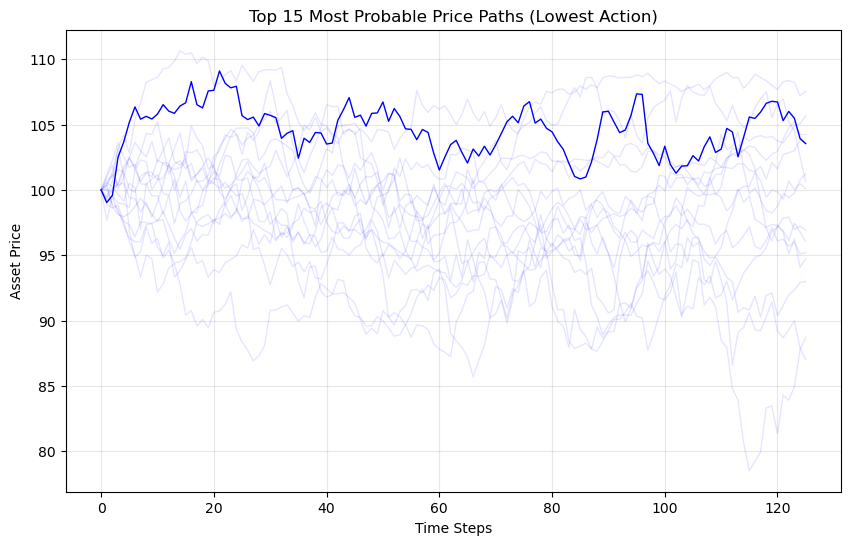

In [5]:
plot_weighted_paths(S_paths, weights, num_to_plot=15, title="Top 15 Most Probable Price Paths (Lowest Action)")

Pricing Options across strikes (Generating Smile)...


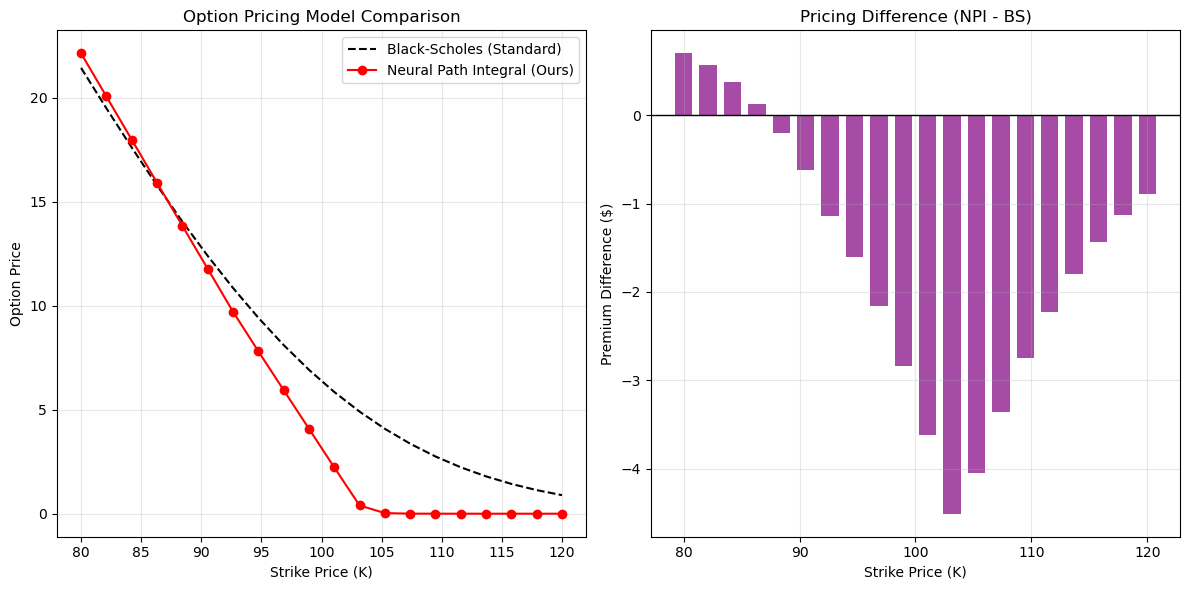

In [6]:
# --- 논문용 최종 분석: Volatility Smile & Pricing Difference ---
# 블랙-숄즈 공식 (비교용)
from scipy.stats import norm

def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# 행사가격 범위 설정 (80 ~ 120)
K_range = np.linspace(80, 120, 20)
npi_prices = []  # 우리 모델 (Neural Path Integral)
bs_prices = []   # 기존 모델 (Black-Scholes)

print("Pricing Options across strikes (Generating Smile)...")

for K_val in K_range:
    # 1. NPI 가격 (Path Integral 가중 평균)
    # 앞서 계산된 S_T(만기 주가)와 weights(가중치)를 그대로 사용합니다.
    payoffs_K = torch.clamp(S_T - K_val, min=0)
    pi_val = torch.sum(payoffs_K * weights) * np.exp(-params['mu'] * T)
    npi_prices.append(pi_val.item())
    
    # 2. BS 가격 (단순 변동성 가정)
    bs_val = black_scholes_call(S0, K_val, T, r=0.03, sigma=np.sqrt(params['theta']))
    bs_prices.append(bs_val)

# 결과 시각화
plt.figure(figsize=(12, 6))

# 왼쪽: 가격 비교
plt.subplot(1, 2, 1)
plt.plot(K_range, bs_prices, 'k--', label='Black-Scholes (Standard)')
plt.plot(K_range, npi_prices, 'r-o', label='Neural Path Integral (Ours)')
plt.title("Option Pricing Model Comparison")
plt.xlabel("Strike Price (K)")
plt.ylabel("Option Price")
plt.legend()
plt.grid(True, alpha=0.3)

# 오른쪽: 가격 차이 (이것이 핵심!)
diffs = np.array(npi_prices) - np.array(bs_prices)
plt.subplot(1, 2, 2)
plt.bar(K_range, diffs, color='purple', alpha=0.7, width=1.5)
plt.axhline(0, color='black', linewidth=1)
plt.title("Pricing Difference (NPI - BS)")
plt.xlabel("Strike Price (K)")
plt.ylabel("Premium Difference ($)")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()